## Topic modelling: tests with the  Latent Dirichlet Allocation (LDA) algorithm.
***

### 1. Initialization of the R environment.
***
The first step is to load the required libraries. 

In [8]:
rm(list=ls()) ## clear objects from memory

options(warn = -1)

library(tm)
library(ggplot2)
library(textmineR)
library(tidytext)
library(dplyr)
library(tidyr)



### 2. Data input.
***

We read two of the files extracted from the database, with the glossary articles definitions in _ESTAT_dat_concepts_2021_04_08.csv_ and their titles in _ESTAT_dat_link_info_2021_04_08.csv_. The common key is _id_. **At a later stage, the reading of the files will be directly from the KD**. 

We then drop articles with missing titles and/or definitions and also de-duplicate the records of the resulting file based on these two fields.



In [9]:
dat1 <- read.csv2('.//Data//ESTAT_dat_concepts_2021_04_08.csv')
dat2 <- read.csv2('.//Data//ESTAT_dat_link_info_2021_04_08.csv')
dat <- merge(dat1,dat2,by=c('id'),all=FALSE)
dat <- dat[,c('title','definition')]

dels <- which(is.na(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(is.na(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

dels <-which(duplicated(dat$title))
if(length(dels)>0) dat <- dat[-dels,]

dels <- which(duplicated(dat$definition))
if(length(dels)>0) dat <- dat[-dels,]

rm(dat1,dat2)


### 3. Data cleaning.
***

In the next step we do some data cleaning: 

* Replace multiple spaces with single ones in definitions.
* Discard spaces at the start of definitions and titles. 
* Replace space-comma-space by comma-space in definitions.


In [10]:
dat$definition <- gsub(' +',' ',dat$definition) ## discard multiple spaces
dat$definition <- gsub('^ +','',dat$definition) ## discard spaces at start
dat$definition <- gsub(' \\, ','\\, ',dat$definition) ## space-comma-space -> comma-space

dat$title <- gsub('^ +','',dat$title) ## discard spaces at start


### 4. Creating tm objects.
***

Next we create a document-term matrix (DTM) _texts_ from the articles. This has initially 1285 rows / text entries. When creating the DTM matrix, we apply some standard pre-processing steps:

* Remove punctuation and numbers. 
* Convert all to lower case.
* Remove stop words.
* Strip whitespace and apply an English stemmer (Porter's stemmer).

The initial number of terms is 5483. We then delete terms with length less than 5 and we keep terms which are in at least 2% and in at most 30% of the documents. We remove documents without terms and we end up with 1281 documents and 467 terms.


In [11]:
texts <- CreateDtm(dat$definition,doc_names=dat$title, ngram_window = c(1, 1),
stopword_vec = c(stopwords::stopwords("en"),
stopwords::stopwords(source = "smart")), lower = TRUE,
remove_punctuation = TRUE, remove_numbers = TRUE,
stem_lemma_function =  function(x) SnowballC::wordStem(x, "porter"), verbose = TRUE)

texts@Dim

ndocs <- nrow(texts) ; nterms <- ncol(texts)
cat('docs = ',ndocs,' terms = ',nterms, '\n')

## min word length: 5, each term in at least 2% of documents 
## and at most in 30% of documents
dels <- which(nchar(texts@Dimnames[[2]]) < 5)
if(length(dels)>0) texts <- texts[,-dels]

dels <- which(colSums(texts) < 0.02*nrow(texts))
if(length(dels)>0) texts <- texts[,-dels]
dels <- which(colSums(texts) > 0.3*nrow(texts))
if(length(dels)>0) texts <- texts[,-dels]

dels <- which(rowSums(texts)==0) #remove all texts without terms 
              
if(length(dels)>0) {
  texts   <- texts[-dels, ]           
  dat <- dat[-dels,]
}

texts@Dim


[1] 1285 5483

docs =  1285  terms =  5483 


[1] 1281  467

We apply the LDA algorithm with k=20 topics. Function _FitLdaModel()_ returns an object which contains, among others, a matrix _phi_ expressing, for each topic and term, the **probability that the term is generated from the specific topic**. For details, see [R package textmineR](https://cran.r-project.org/web/packages/textmineR/index.html). 

In the following code, we first group the results by topic and then select the terms with the top _beta_ values in each topic.Then we plot these values and the corresponding terms for each topic.

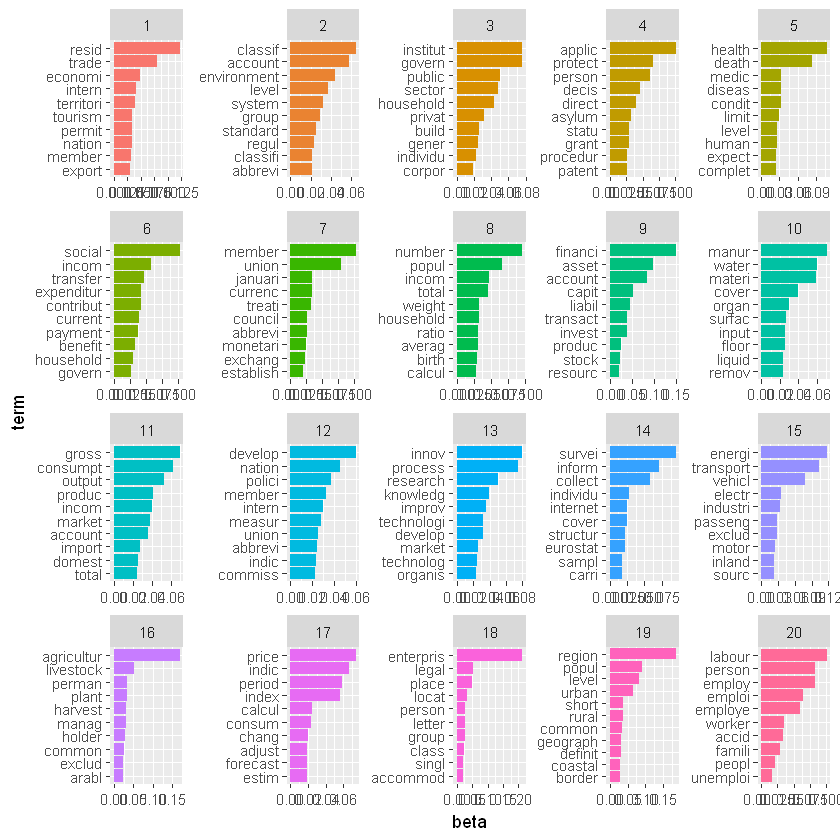

In [12]:
lda_model <- 
  FitLdaModel(texts, k=20, iterations = 500, burnin = 400, alpha = 0.1,
beta = 0.05, optimize_alpha = TRUE, calc_likelihood = FALSE,
calc_coherence = TRUE, calc_r2 = FALSE)

tidy_beta <- data.frame(topic = as.integer(stringr::str_replace_all(rownames(lda_model$phi), "t_", "")), 
                        lda_model$phi, stringsAsFactors = FALSE) %>%
  gather(term, beta, -topic) %>% 
  tibble::as_tibble()

  
top_terms <- tidy_beta %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>% 
  ungroup() %>%
  arrange(topic, -beta)

top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  scale_y_reordered()


### CORRECT BELOW ###

The results with the top 10 terms by topic can be interpreted as follows: 

* Topic 1: Social expenditure and contributions.
* Topic 2: Population, regions and geography. 
* Topic 3: Persons and employment.
* Topic 4: Intellectual property rights. 
* Topic 5: Economic sectors.
* Topic 6: Public services.
* Topic 7: International trade.
* Topic 8: Price indices. 
* Topic 9: Surveys.
* Topic 10: Technology, research and innovation.
* Topic 11: Countries, territories and resident population.
* Topic 12: Business activities and enterprises.
* Topic 13: Transport. 
* Topic 14: Primary production and the environment.
* Topic 15: The EU and the member states.
* Topic 16: Energy and water resources.
* Topic 17: Accounting and finance.
* Topic 18: Healthcare.
* Topic 19: Households disposable income and consumption.
* Topic 20: Production, consumption and gross capital.

If these results are useful, the analysis will be extended to take into account the _gamma_ coefficients which express, for each document and topic, the **estimated proportion of terms from the document that are generated from that topic**.

